<a href="https://colab.research.google.com/github/afraAntara/507_project/blob/main/Damped_RK4_TPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

class RungeKuttaNNPyTorch(nn.Module):
    def __init__(self, timestep, t_init, t_end, n_var, n_out, n_oppar, n_hidden1=10):
        super(RungeKuttaNNPyTorch, self).__init__()
        self.timestep = timestep
        self.t_init = t_init
        self.t_end = t_end
        self.n_var = n_var
        self.n_out = n_out
        self.n_oppar = n_oppar
        self.n_inputs = n_var + n_oppar

        # Define the layers
        self.layer_1 = nn.Linear(self.n_inputs, n_hidden1)
        # self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.output_layer = nn.Linear(n_hidden1, n_out)

    def ann(self, y, a, x):
        # Forward pass through the network
        stack = torch.cat([y, a, x], dim=1)
        layer_1_out = torch.sigmoid(self.layer_1(stack))
        # layer_2_out = torch.relu(self.layer_2(layer_1_out))
        out = self.output_layer(layer_1_out)
        return out


    def ode(self, y, a, c, x):
        # ODE function where ANN is used
        out = self.ann(y, a, x) + c
        return out

    def forward(self, y, a, c, x):
        # Runge-Kutta 4th order integration
        dt = self.timestep
        k1 = dt * self.ode(y, a, c, x)
        k2 = dt * self.ode(y + 0.5 * k1, a, c, x)
        k3 = dt * self.ode(y + 0.5 * k2, a, c, x)
        k4 = dt * self.ode(y + k3, a, c, x)
        out = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return out

# Instantiate the model with arbitrary parameters
model = RungeKuttaNNPyTorch(timestep=0.01, t_init=0, t_end=10, n_var=2, n_out=1, n_oppar=1)

# Print model structure
print(model)

RungeKuttaNNPyTorch(
  (layer_1): Linear(in_features=3, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


#State ODE function

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import random

def ode_solution(timestep, t_init, t_end):
    a = 0.5  # Example value for k
    # Define the range of 'c' from 1 to 10
    c_values = range(1, 100)

    def f(y, a):
      return -a * y


    # Define the ODE function
    def ode_function(y, a, c):
        return f(y, a) + c

    # Define the Runge-Kutta 4 method step
    def rk4_step(f, t, y, h, a, c):
        k1 = h * f(y, a, c)
        k2 = h * f(y + 0.5 * k1, a, c)
        k3 = h * f(y + 0.5 * k2, a, c)
        k4 = h * f(y + k3, a, c)
        return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    # Parameters for solving the ODE
    t0 = t_init
    y0 = 0  # Initial condition
    h = timestep  # Step size
    # Initialize arrays for t values and y values
    t_values = np.arange(t0, t_end, h)
    y_values = [y0]
    c = random.choice(list(c_values))
    c_val = [c]
    a_val = [a] * len(t_values)

    # Solving the ODE using RK4 method
    for t in t_values[:-1]:
        c_val.append(c)
        if round(t) % 10 == 0:
            # Select a random value from c_values
            c = random.choice(list(c_values))
        y_values.append(rk4_step(ode_function, t, y_values[-1], h, a, c))

    data = np.column_stack((t_values, y_values, a_val, c_val))

    return data


def plot(data):
    t = data[:,0]
    y = data[:,1]
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(t, y)
    plt.title('Solution of the ODE')
    plt.xlabel('Timesteps')
    plt.ylabel('x(t)')
    plt.grid(True)
    plt.show()

# plot(solution_data)



#Generate train test

In [178]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


# Function to set and normalize the data
def set_data(timestep, t_init, t_end):
    t = np.arange(t_init, t_end, timestep)
    data = ode_solution(timestep, t_init, t_end)
    # print("data",data)
    mean = np.mean(data)
    data -= mean
    std = np.std(data)
    data /= std
    return data, mean, std


# in the data matrix, o=y, 1=t, 2=a, 3=o, 4= l, 5=x
# Function to prepare the data for training
def prepare_data(timestep, t_init, t_end, test_ratio):
    data, _, _ = set_data(timestep, t_init, t_end)
    # print("normalised",data)
    n_samples = data.shape[0]
    n_timesteps = n_samples - 1
    # input_t = data[:n_timesteps, 0].reshape((-1,1))
    # print("t", input_t)
    input_y = data[:n_timesteps, 1].reshape((-1,1))
    # print("y", input_y)
    input_a = data[:n_timesteps, 2].reshape((-1,1))
    input_c = data[:n_timesteps, 3].reshape((-1,1))
    # print("a", input_a)
    output_y = data[1:, 1].reshape((-1,1))
    # print("out:",output_y)
    input_x = np.zeros((n_samples, 1))  # Trivial parameter in this example
    input_x = input_x[:n_timesteps]
    joint = np.hstack((input_y, input_a, input_c, input_x))
    # print("joint:",joint)


    # Split data into train and test sets
    train_input, test_input, train_output, test_output = train_test_split(
        joint, output_y, test_size=test_ratio, random_state=42)

    # print("train_i", train_input)
    # print("test_i", test_input)
    # print("train_o", train_output)
    # print("test_o", test_output)

    # # Convert to PyTorch tensors
    train_input_tensor = torch.tensor(train_input, dtype=torch.float32)
    test_input_tensor = torch.tensor(test_input, dtype=torch.float32)
    train_output_tensor = torch.tensor(train_output, dtype=torch.float32)
    test_output_tensor = torch.tensor(test_output, dtype=torch.float32)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    output_tensor = torch.tensor(output_y, dtype=torch.float32)


    return data_tensor, output_tensor, train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor



# Initialize model parameters
timestep = 0.1
t_init = 0
t_end = 1000
test_ratio = 0.1

# prepare_data(timestep, t_init, t_end, test_ratio)


# Prepare the data
data_tensor, output_tensor, train_input, test_input, train_output, test_output = prepare_data(timestep, t_init, t_end, test_ratio)

# print(data_tensor)
# print(output_tensor)

Train Model

Iteration 1/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 2/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 3/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 4/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 5/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 6/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 7/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 8/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 9/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 10/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 11/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 12/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 13/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 14/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 15/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 16/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 17/50 - Train Loss: 0.0000, Test Loss: 0.0000
Iteration 18/50 - Train Loss: 0.0000, Test Loss: 0.0000
I

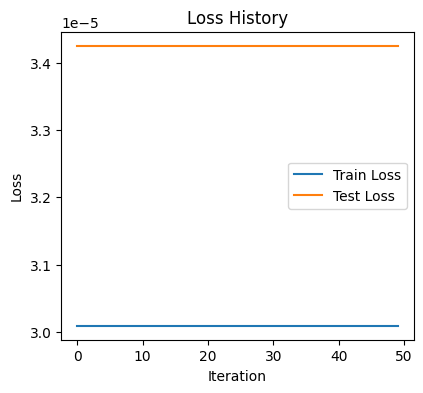

In [179]:
import torch.optim as optim

# Assuming the class RungeKuttaNNPyTorch and other necessary functions are already defined as per the user's code

# Initialize the model
n_var = 2  # Number of variables in ODE
n_out = 1
n_oppar = 1  # Number of operational parameters
model = RungeKuttaNNPyTorch(timestep, t_init, t_end, n_var, n_out, n_oppar)

# Lists to store loss history
train_loss_history = []
test_loss_history = []
def train_model(model, train_input, train_output, test_input, test_output, max_iter=100):
    # Define the MSE loss function
    criterion = nn.MSELoss()

    # Parameters for optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=max_iter, history_size=10)

    # Lists to store loss history
    train_loss_history = []
    test_loss_history = []

    # Function to calculate loss
    def loss_fn(pred, target):
        return criterion(pred, target)

    # Closure function for L-BFGS optimization
    def closure():
        optimizer.zero_grad()
        outputs = model.forward(train_input[:, 0:1], train_input[:, 1:2], train_input[:, 2:3], train_input[:, 3:4])
        # print(outputs, train_output)
        loss = loss_fn(outputs, train_output)
        loss.backward()
        return loss

    # Training loop
    for i in range(max_iter):
        # Optimization step
        optimizer.step(closure)

        # Calculate and record training loss
        with torch.no_grad():
            train_pred = model.forward(train_input[:, 0:1], train_input[:, 1:2], train_input[:, 2:3], train_input[:, 3:4])
            train_loss = loss_fn(train_pred, train_output).item()
            test_pred = model.forward(test_input[:, 0:1], test_input[:, 1:2], test_input[:, 2:3], test_input[:, 3:4])
            test_loss = loss_fn(test_pred, test_output).item()

            # Append to history
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)

            print(f"Iteration {i+1}/{max_iter} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting the training and testing loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()


# model = RungeKuttaNNPyTorch(...)
train_model(model, train_input, train_output, test_input, test_output, max_iter=50)


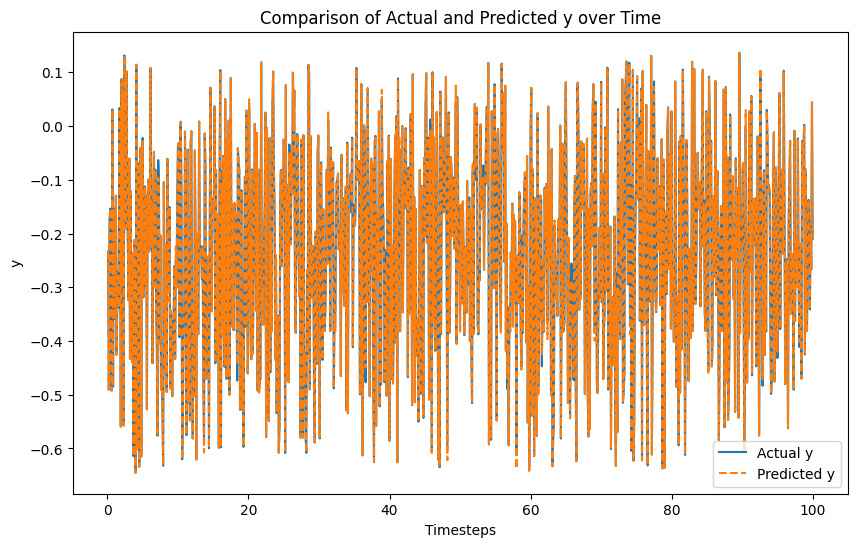

In [185]:
import matplotlib.pyplot as plt

# Load the model if saved
# model = RungeKuttaNNPyTorch(...)
# model.load_state_dict(torch.load('model.pth'))

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model.forward(test_input[:,0:1], test_input[:,1:2], test_input[:,2:3], test_input[:,3:4])

# Convert predictions and test_output to numpy for plotting
y_pred_np = y_pred.numpy()
test_output_np = test_output.numpy()

# Calculate time steps for plotting
t = np.arange(t_init, t_end, timestep)
t = t[1:]  # Adjust for shifted output in the data preparation
t_test = t[:len(test_output_np)]  # Adjust to the length of the test data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_test, test_output_np, label='Actual y')
plt.plot(t_test, y_pred_np, label='Predicted y', linestyle='--')
plt.xlabel('Timesteps')
plt.ylabel('y')
plt.title('Comparison of Actual and Predicted y over Time')
plt.legend()
plt.show()


Test Loss: 0.0000


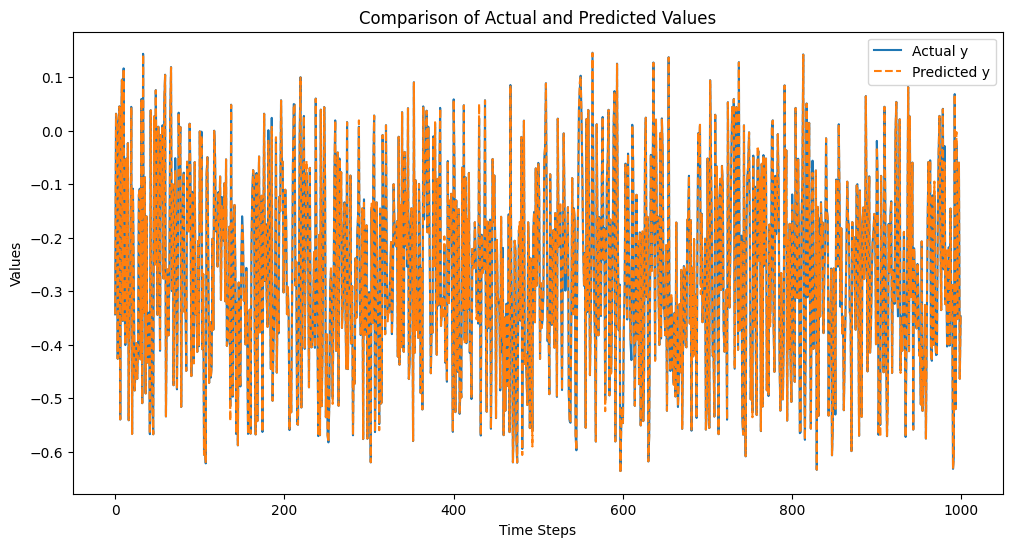

In [160]:
import matplotlib.pyplot as plt

def test_model(model, test_input, test_output):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_pred = model.forward(test_input[:,0:1], test_input[:,1:2], test_input[:,2:3], test_input[:,3:4])
                # Calculate Loss: Mean Squared Error
        criterion = nn.MSELoss()
        loss = criterion(test_pred, test_output)
        # Split the test input into y and x
        # test_y = test_input[:, 0]
        # test_a = test_input[:, 1]
        # test_c = test_input[:, 2]
        # test_x = test_input[:, 3]

        # # Forward pass to get output/predictions
        # predictions = model.forward(test_y, test_a, test_c, test_x)


    return test_pred, loss.item()

# Testing the model and getting the loss
predictions, test_loss = test_model(model, test_input, test_output)
print(f"Test Loss: {test_loss:.4f}")

# Visualize the results
def visualize_predictions(test_output, predictions):
    # Converting tensors to numpy arrays
    test_output_np = test_output.numpy()
    predictions_np = predictions.numpy()

    plt.figure(figsize=(12, 6))
    # plt.plot(test_output_np[:, 0], label='Actual Y1')
    # plt.plot(predictions_np[:, 0], label='Predicted Y1')
    plt.plot(test_output_np, label='Actual y')
    plt.plot(predictions_np, label='Predicted y', linestyle='--')
    plt.title("Comparison of Actual and Predicted Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

# To visualize, uncomment and run the following line after testing the model
visualize_predictions(test_output, predictions)

# Note: Ensure that the model has been defined and trained before testing and visualizing.
# Uncomment the relevant lines to perform these actions.


data [[0.00000000e+00 0.00000000e+00 5.00000000e-01 2.20000000e+01]
 [1.00000000e-01 7.51066823e+00 5.00000000e-01 2.20000000e+01]
 [2.00000000e-01 1.23140494e+01 5.00000000e-01 7.70000000e+01]
 ...
 [9.97000000e+01 1.57275403e+02 5.00000000e-01 8.20000000e+01]
 [9.98000000e+01 1.55847625e+02 5.00000000e-01 8.80000000e+01]
 [9.99000000e+01 1.48539471e+02 5.00000000e-01 6.40000000e+01]]


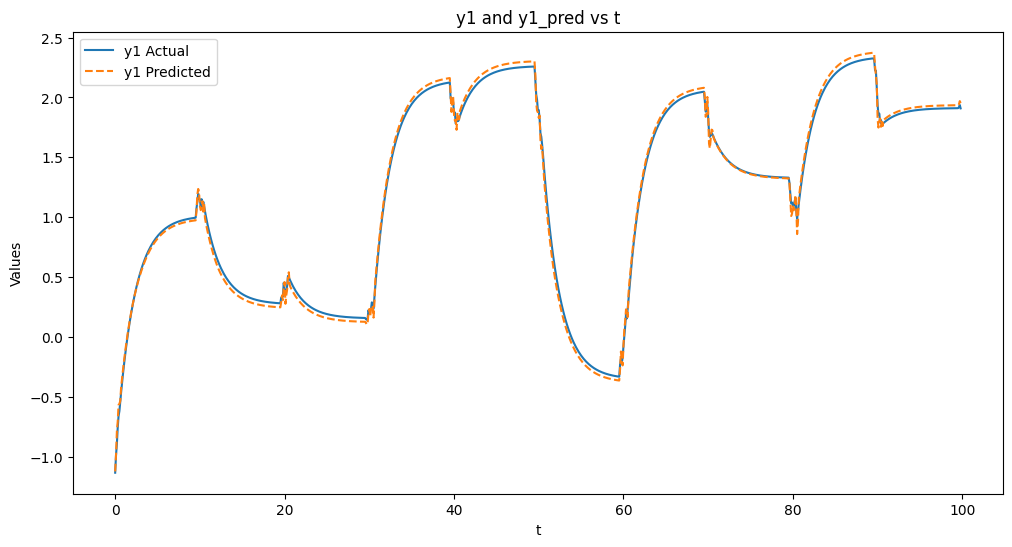

In [162]:
import numpy as np
import torch
from matplotlib import pyplot as plt

# Time step parameters
timestep = 0.1
t_init = 0
t_end = 100
num_it = int((t_end-t_init)/timestep)
# Assuming the set_data and prepare_data functions, model initialization, and parameters timestep, t_init, t_end are defined

# Prepare the data
data, _, _ = set_data(timestep, t_init, t_end)
# print(data.shape)

# Convert the data to a PyTorch tensor and normalize it
data_tensor = torch.tensor(data, dtype=torch.float32)

# Prepare predictions for all values of t
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for i in range(data_tensor.shape[0] - 1):  # Subtract 1 because we use data[i + 1] as output
        # Append a zero (trivial parameter) and unsqueeze to add a batch dimension
        data_point = torch.cat((data_tensor[i], torch.tensor([0.0])), dim=0).unsqueeze(0)

        # Split into y and x
        y = data_point[:, 1:2]
        a = data_point[:, 2:3]
        c = data_point[:, 3:4]
        x = data_point[:, 4:]

        # Get the model's prediction and store it
        prediction = model.forward(y, a, c, x)
        predictions.append(prediction)

# Convert list of tensors to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Extract y1, y2 and their predictions
y1_actual = data_tensor[:-1, 1].numpy()  # Ignore last point as there's no prediction for it
y1_pred = predictions_tensor[:, 0].numpy()


# Generate t values
t_values = np.arange(t_init, t_end, timestep)[:len(y1_actual)]

# Plot y1 and y1_pred against t
plt.figure(figsize=(12, 6))

plt.plot(t_values, y1_actual, label='y1 Actual')
plt.plot(t_values, y1_pred, label='y1 Predicted', linestyle='--')
plt.title('y1 and y1_pred vs t')
plt.xlabel('t')
plt.ylabel('Values')
plt.legend()

plt.show()



#Model 2

Iteration 1/300 - Train Loss: 0.0046, Test Loss: 0.0045
Iteration 2/300 - Train Loss: 0.0045, Test Loss: 0.0044
Iteration 3/300 - Train Loss: 0.0044, Test Loss: 0.0043
Iteration 4/300 - Train Loss: 0.0043, Test Loss: 0.0042
Iteration 5/300 - Train Loss: 0.0042, Test Loss: 0.0041
Iteration 6/300 - Train Loss: 0.0041, Test Loss: 0.0041
Iteration 7/300 - Train Loss: 0.0041, Test Loss: 0.0040
Iteration 8/300 - Train Loss: 0.0040, Test Loss: 0.0039
Iteration 9/300 - Train Loss: 0.0039, Test Loss: 0.0038
Iteration 10/300 - Train Loss: 0.0038, Test Loss: 0.0037
Iteration 11/300 - Train Loss: 0.0038, Test Loss: 0.0037
Iteration 12/300 - Train Loss: 0.0037, Test Loss: 0.0036
Iteration 13/300 - Train Loss: 0.0036, Test Loss: 0.0035
Iteration 14/300 - Train Loss: 0.0035, Test Loss: 0.0035
Iteration 15/300 - Train Loss: 0.0035, Test Loss: 0.0034
Iteration 16/300 - Train Loss: 0.0034, Test Loss: 0.0033
Iteration 17/300 - Train Loss: 0.0033, Test Loss: 0.0032
Iteration 18/300 - Train Loss: 0.0033, T

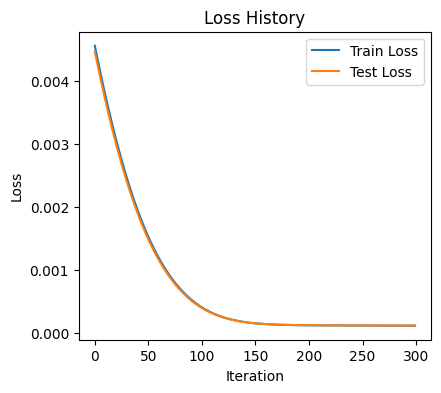

In [186]:
# Modified training function to use Adam optimizer
import torch.optim as optim

# Assuming the class RungeKuttaNNPyTorch and other necessary functions are already defined as per the user's code

# Initialize the model
n_var = 2  # Number of variables in ODE
n_out = 1
n_oppar = 1  # Number of operational parameters
model2 = RungeKuttaNNPyTorch(timestep, t_init, t_end, n_var, n_out, n_oppar)

# Lists to store loss history
train_loss_history = []
test_loss_history = []

def train_model(model, train_input, train_output, test_input, test_output, max_iter=100):
    # Define the MSE loss function
    criterion = nn.MSELoss()

    # Parameters for optimizer - using Adam instead of LBFGS
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store loss history
    train_loss_history = []
    test_loss_history = []

    # Training loop
    for i in range(max_iter):
        optimizer.zero_grad()

        # Forward pass
        train_pred = model2.forward(train_input[:, 0:1], train_input[:, 1:2], train_input[:, 2:3], train_input[:, 3:4])
        train_loss = criterion(train_pred, train_output)

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # Calculate and record testing loss
        with torch.no_grad():
            test_pred = model2.forward(test_input[:, 0:1], test_input[:, 1:2], test_input[:, 2:3], test_input[:, 3:4])
            test_loss = criterion(test_pred, test_output)

            # Append to history
            train_loss_history.append(train_loss.item())
            test_loss_history.append(test_loss.item())

            print(f"Iteration {i+1}/{max_iter} - Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # Plotting the training and testing loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    plt.show()

# Note: The model initialization and data preparation should be done prior to calling this function.
# Example:
# model = RungeKuttaNNPyTorch(...)
train_model(model2, train_input, train_output, test_input, test_output, max_iter=300)


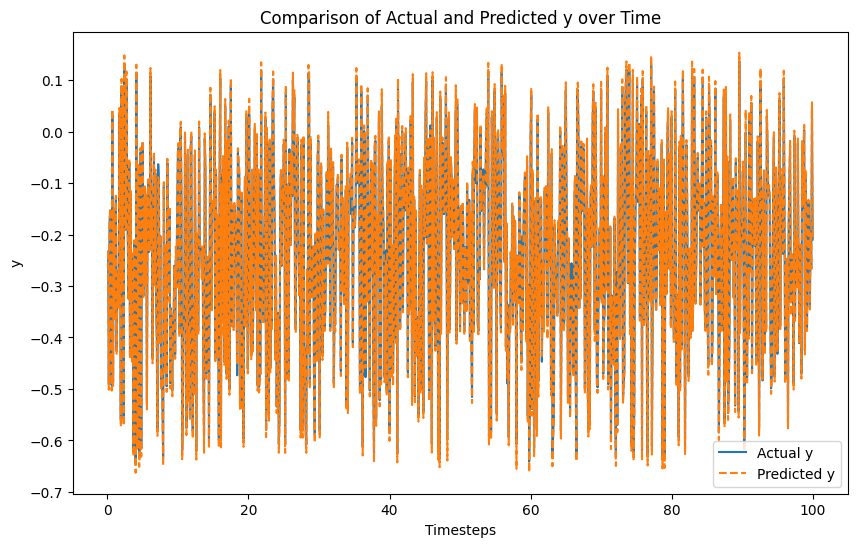

In [187]:
import matplotlib.pyplot as plt

# Load the model if saved
# model = RungeKuttaNNPyTorch(...)
# model.load_state_dict(torch.load('model.pth'))

# Make predictions
model2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model2.forward(test_input[:,0:1], test_input[:,1:2], test_input[:,2:3], test_input[:,3:4])

# Convert predictions and test_output to numpy for plotting
y_pred_np = y_pred.numpy()
test_output_np = test_output.numpy()

# Calculate time steps for plotting
t = np.arange(t_init, t_end, timestep)
t = t[1:]  # Adjust for shifted output in the data preparation
t_test = t[:len(test_output_np)]  # Adjust to the length of the test data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_test, test_output_np, label='Actual y')
plt.plot(t_test, y_pred_np, label='Predicted y', linestyle='--')
plt.xlabel('Timesteps')
plt.ylabel('y')
plt.title('Comparison of Actual and Predicted y over Time')
plt.legend()
plt.show()


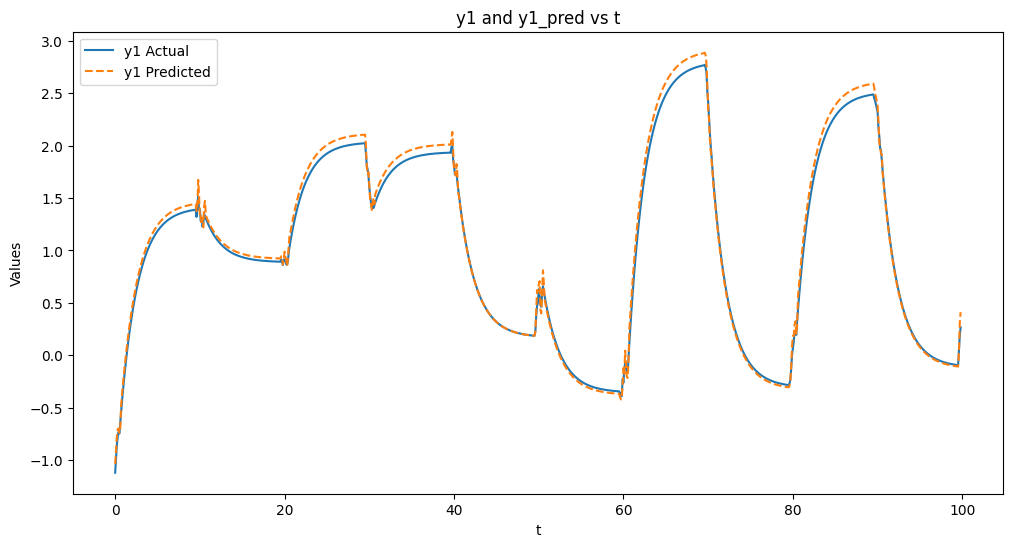

In [189]:
import numpy as np
import torch
from matplotlib import pyplot as plt

# Time step parameters
timestep = 0.1
t_init = 0
t_end = 100
num_it = int((t_end-t_init)/timestep)
# Assuming the set_data and prepare_data functions, model initialization, and parameters timestep, t_init, t_end are defined

# Prepare the data
data, _, _ = set_data(timestep, t_init, t_end)
# print(data.shape)

# Convert the data to a PyTorch tensor and normalize it
data_tensor = torch.tensor(data, dtype=torch.float32)

# Prepare predictions for all values of t
model2.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for i in range(data_tensor.shape[0] - 1):  # Subtract 1 because we use data[i + 1] as output
        # Append a zero (trivial parameter) and unsqueeze to add a batch dimension
        data_point = torch.cat((data_tensor[i], torch.tensor([0.0])), dim=0).unsqueeze(0)

        # Split into y and x
        y = data_point[:, 1:2]
        a = data_point[:, 2:3]
        c = data_point[:, 3:4]
        x = data_point[:, 4:]

        # Get the model's prediction and store it
        prediction = model2.forward(y, a, c, x)
        predictions.append(prediction)

# Convert list of tensors to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Extract y1, y2 and their predictions
y1_actual = data_tensor[:-1, 1].numpy()  # Ignore last point as there's no prediction for it
y1_pred = predictions_tensor[:, 0].numpy()


# Generate t values
t_values = np.arange(t_init, t_end, timestep)[:len(y1_actual)]

# Plot y1 and y1_pred against t
plt.figure(figsize=(12, 6))

plt.plot(t_values, y1_actual, label='y1 Actual')
plt.plot(t_values, y1_pred, label='y1 Predicted', linestyle='--')
plt.title('y1 and y1_pred vs t')
plt.xlabel('t')
plt.ylabel('Values')
plt.legend()

plt.show()

